# Using *ceffyl* on a PTA free spectrum

A free spectrum of the PTA is easy to refit spectra using *ceffyl*. Simply choose your spectrum from *ceffyl.model* (or create your own function!), along with the number of frequencies that you want to search over, and let your MCMC run!

First off, let's import some required packages...

In [ ]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import corner
from ceffyl import Ceffyl, models, Sampler, chain_utils
from enterprise.signals import parameter
import ultranest

import la_forge.core as co
import la_forge.diagnostics as dg

## PTA free spectrum

The free spectrum is a model-independent analysis of the timing residuals from the PTA [(Lentati et. al. 2013)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.104021). For a PTA free spectrum, we typically model 30 frequency power-laws for each pulsar's intrinsic red noise, as well as a common free-spectrum process instead of an e.g power-law common process. We recover posteriors at each sampled GW frequency that represents the common process' cross-power spectrum at that frequency bin. The posteriors are represented by the coefficient $\rho$, where $$\rho^2(f_k) = \prod_{a,b}\frac{\Gamma_{pq}S_{pq}(f_k)}{T} = \prod_a\frac{S_{aa}(f_k)}{T}$$ for a pulsar $p$ at a frequency bin $f_k$ for $k \in [1, N_f]$, $S$ is the timing-residual cross-power spectrum, $T$ is the PTA timing baseline, and $\Gamma_{pq}=\delta_{pq}$ is the overlap reduction function between pulsars $p$ and $q$, which we assume to be independent, hence the Dirac delta function.

We run the free spectrum with [`enterprise`](https://github.com/nanograv/enterprise).

Let's see what the free spectrum looks like for a simulated pulsar timing array (simulation based on [Pol et. al. 2021](http://dx.doi.org/10.3847/2041-8213/abf2c9))

In [4]:
# DON'T RUN THIS BLOCK!
# freespec = co.Core(corepath='../data/sim51/freespec_sim51/freespec_2A_30f.core')

Text(0, 0.5, '$\\log_{10}$ CP delay [s]')

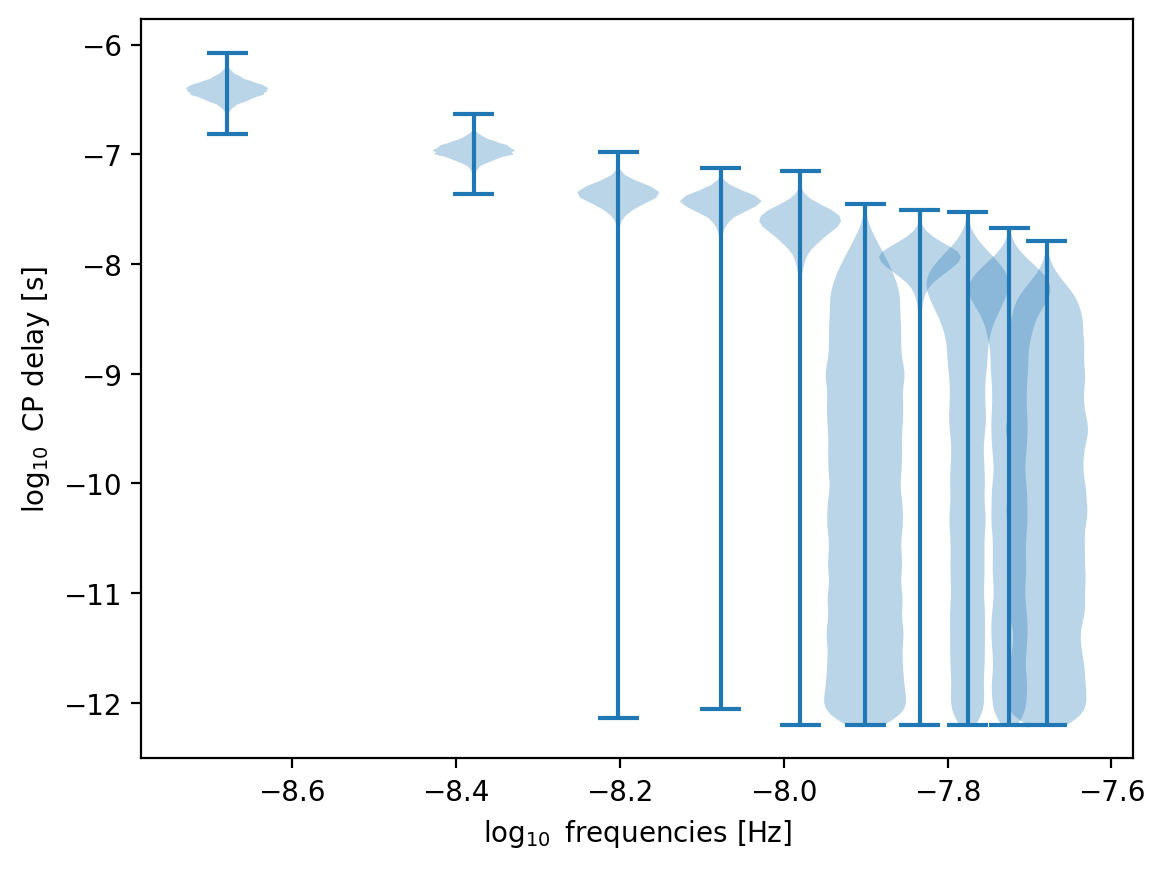

In [6]:
""" # DON'T RUN THIS BLOCK!
plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
"""

The injected values for this simulation are:

In [3]:
log10A_inj, gamma_inj = np.loadtxt('../data/sim51/injected_values.txt')
print(f'log10A={log10A_inj}, gamma={gamma_inj}')

log10A=-14.6985, gamma=4.1727


## Now let's fit some GW models!

To fit our GW models onto our free spectrum, we must represent our posteriors as probability density functions in order to extract probabilities to build a Bayesian likelihood. Using the most optimal kernel density estimators (KDEs, see paper for details), we can create a grid of probabilities to select from.

For details on creating your own probability grids, see [link to another ipynb being developed]. However, these grids will be made for you in advance for most PTA data sets so all you have to do is use them! :)

let's initialise a Ceffyl object to approximate a PTA using the PTA free spectrum. A directory containing the KDE densities of our simulated PTA free spectrum is our input. It also contains metadata on the frequencies used, pulsar names etc.

In [5]:
pta = Ceffyl.ceffyl(datadir='../data/sim51/freespec_sim51/')

Define a GW spectrum! Let's try a 5f powerlaw. The default parameters here are $\log_{10}A\in[-18,-12]$, $\gamma\in[0,7]$

In [6]:
gw = Ceffyl.signal(psd=models.powerlaw, N_freqs=5)

Adding signals is easy!

In [7]:
pta.add_signals([gw])

Now let's setup and run our sampler

In [8]:
sampler = Sampler.setup_sampler(pta, 
                                outdir='../data/sim51/refits/freespec/5fpl/',
                                logL=pta.ln_likelihood,
                                logp=pta.ln_prior, resume=False)
x0 = pta.initial_samples()  # get initial sample

Adding GWB uniform distribution draws...



In [9]:
sampler.sample(x0, int(200000))  # sample!

Finished 0.50 percent in 0.210319 s Acceptance rate = 0.369

/Users/lambwg/miniforge3/envs/ceffyl/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 5.00 percent in 1.913734 s Acceptance rate = 0.216467Adding DE jump with weight 20
Finished 100.00 percent in 39.644670 s Acceptance rate = 0.382795
Run Complete


Let's read the data from the analysis

In [15]:
# this compresses the output file
c0 = co.Core('../data/sim51/refits/freespec/5fpl/')
c0.set_rn_freqs(freqs=pta.freqs[:5])
c0.save('../data/sim51/refits/freespec/5fpl/chain.core')
pl5f = co.Core(corepath='../data/sim51/refits/freespec/5fpl/chain.core')

checking the traceplot to see if the chains converged

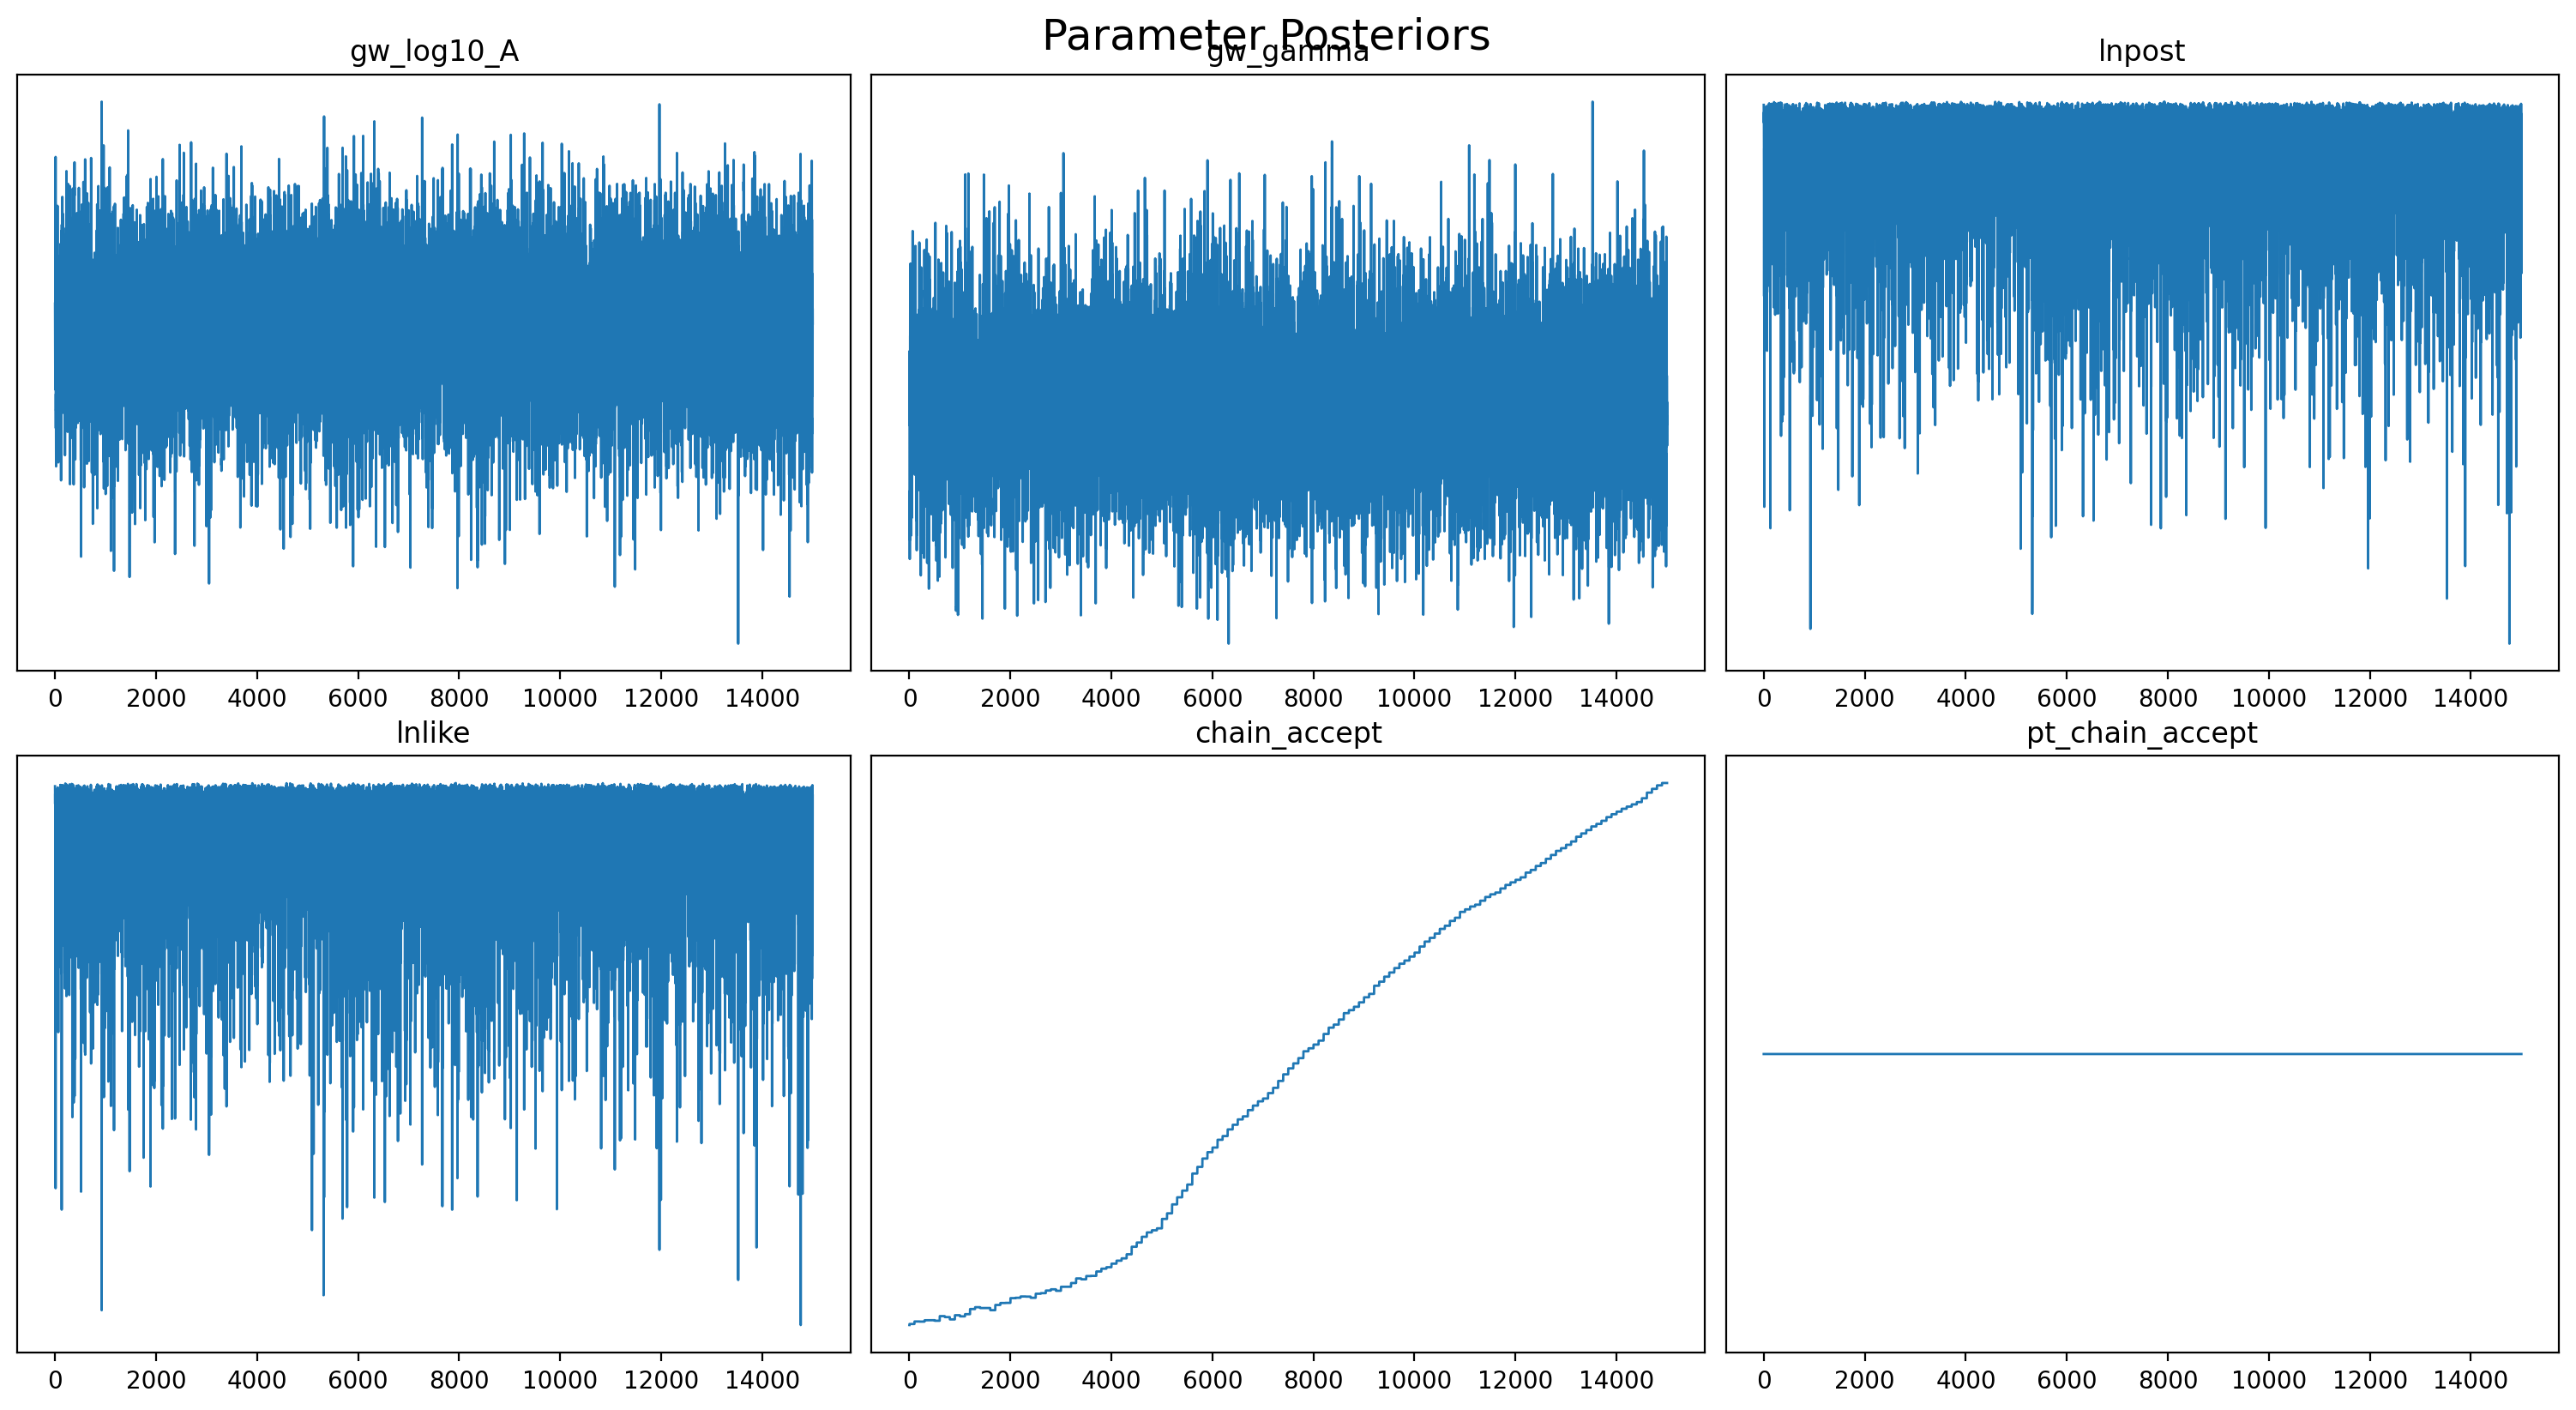

In [16]:
dg.plot_chains(pl5f, hist=False)

let's also numerical check if it has converged. If all points are below the dashed line, we are good to go (but to be safe, you should also check if all parameters have small autocorrelations lengths too by using `emcee.autocorr`

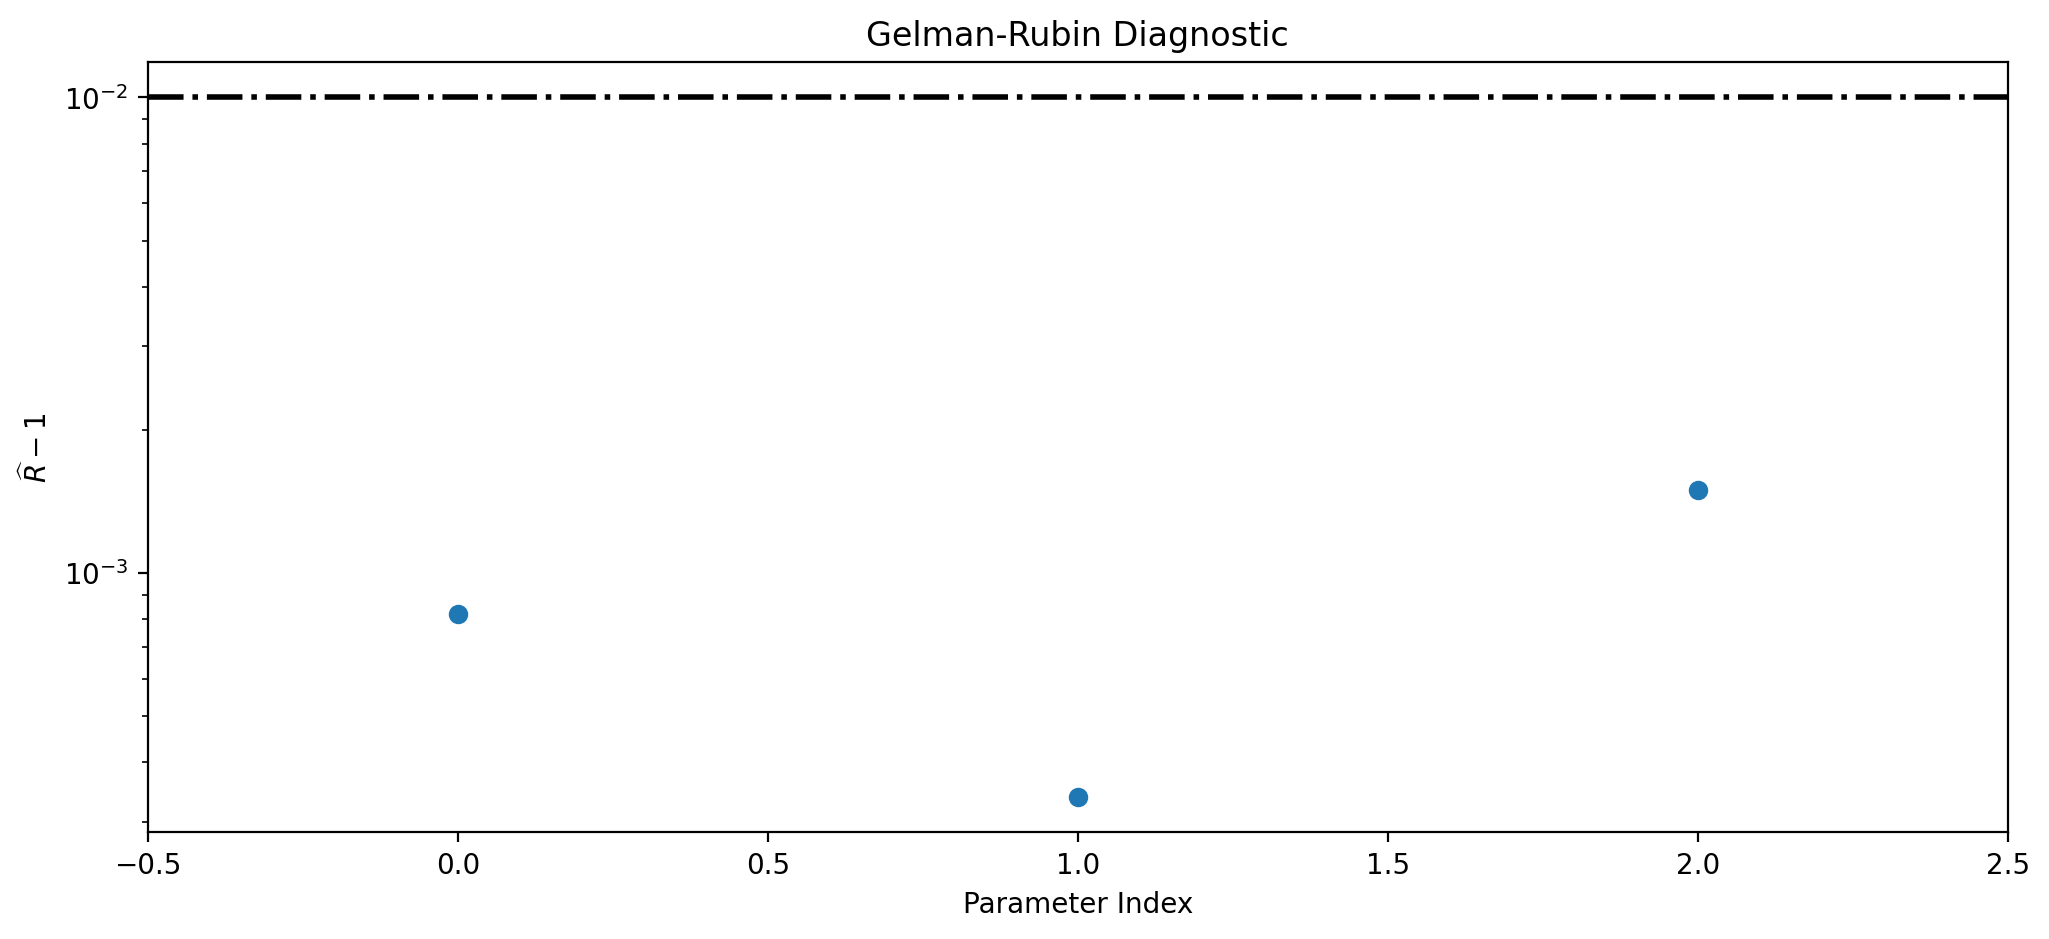

In [17]:
dg.plot_grubin(pl5f)

Let's make a corner plot!

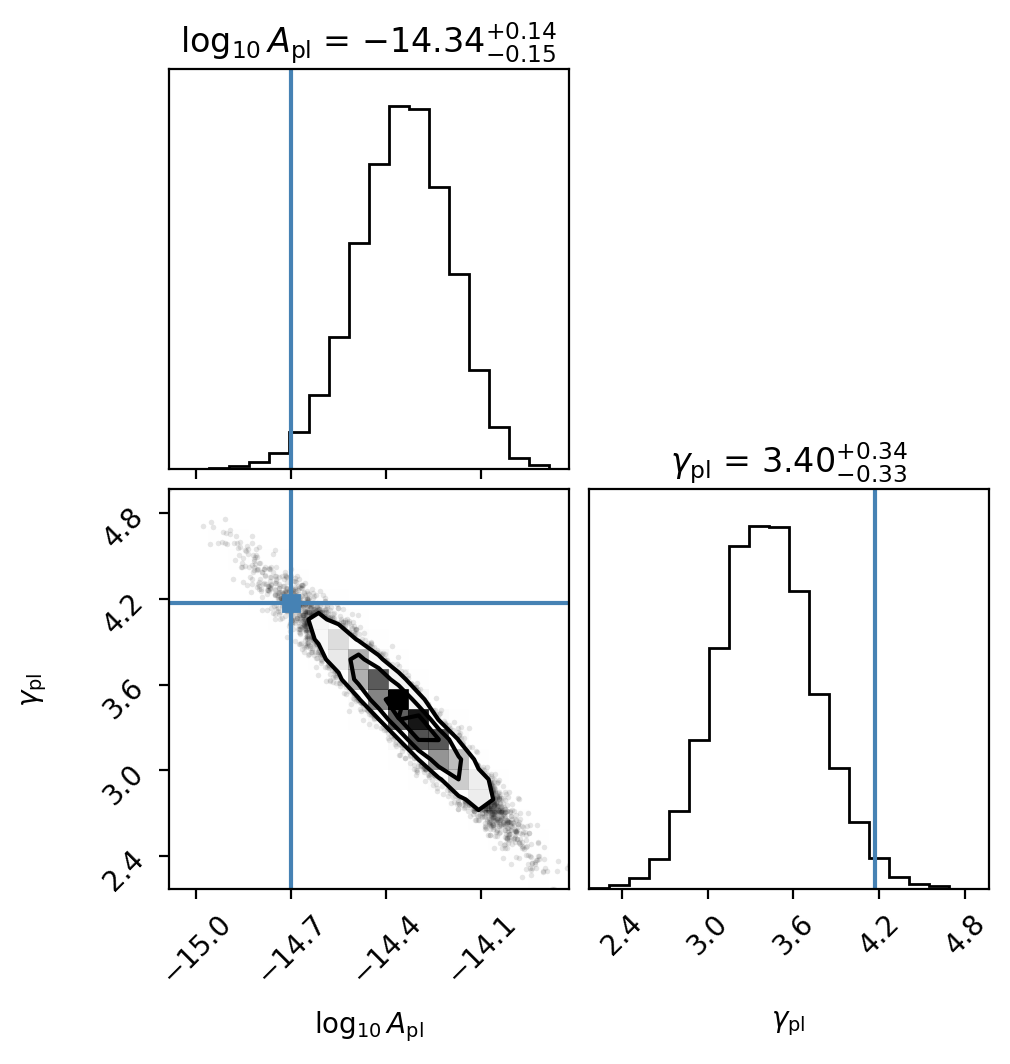

In [19]:
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\gamma_\mathrm{pl}$']

corner.corner(pl5f(pl5f.params[:2]), labels=tex,
              show_titles=True, truths=[log10A_inj, gamma_inj]);

The 'truth' lines are the injected powerlaw parameters. Our analysis captures the injection well within the 95% credible region. This is good, but we should compare it to a typical uncorrelated powerlaw analysis. See Fig 3. of [Lamb, Taylor & van Haasteren 2023]().

Let's take the maximum likelihood parameters from this run and plot it on the free spectrum. We'll compare it to the injected powerlaw

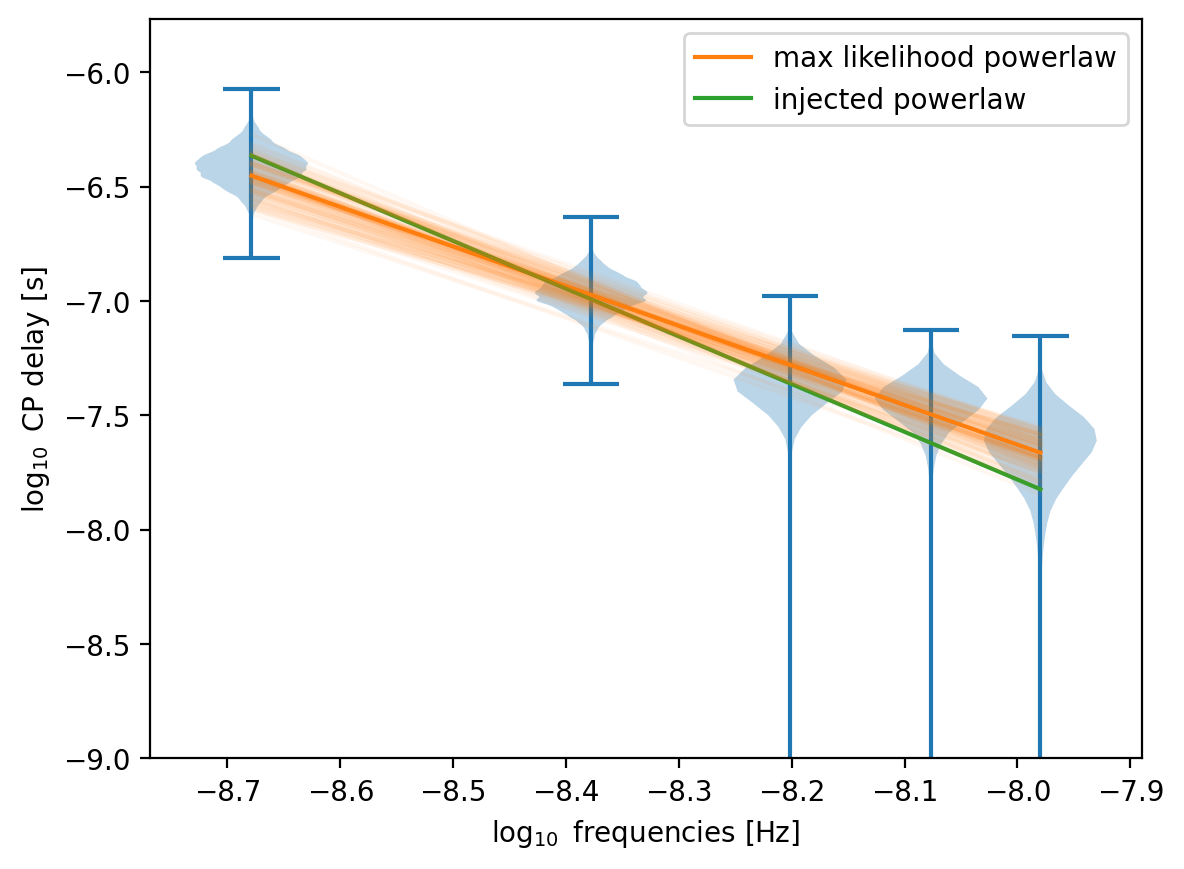

In [27]:
""" # DON'T RUN THIS BLOCK!
idx = np.where(pl5f('lnpost').max()==pl5f('lnpost'))[0][0]
log10_A, gamma = pl5f.chain[pl5f.burn:][idx][:2]
pl = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs,
                                  Tspan=1/pl5f.rn_freqs[0],
                                  log10_A=log10_A,
                                  gamma=gamma))

idx = np.random.randint(0, pl5f.chain[pl5f.burn:].shape[0],
                        100)
log10_A, gamma = pl5f.chain[pl5f.burn:][idx][:,:2].T
plspread = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs[None,:].T,
                                        Tspan=1/pl5f.rn_freqs[0],
                                        log10_A=log10_A,
                                        gamma=gamma))

pl_inj = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs,
                                      Tspan=1/pl5f.rn_freqs[0],
                                      log10_A=log10A_inj,
                                      gamma=gamma_inj))

plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-10])),
               positions=np.log10(freespec.rn_freqs[:5]),
               widths=0.1)
plt.plot(np.log10(pl5f.rn_freqs), pl, label='max likelihood powerlaw')
plt.plot(np.log10(pl5f.rn_freqs), pl_inj, label='injected powerlaw')
plt.plot(np.log10(pl5f.rn_freqs), plspread, color='C1',
         alpha=0.05)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
plt.ylim(-9)
plt.legend();
"""

##### What if I want to try a different model?

Then just change the model function... All models supported right now are found in `ceffyl.models`. *These are equivalent to the functions in `enterprise.gp_priors`, except they're faster as the don't require repeated frequencies and they are vectorised. Note that the functions in `enterprise.gp_priors` will not work with `ceffyl`.*

What about a broken powerlaw with *fixed* $\gamma$?
We fix a value by defining it in the dictionary labelled `const_params`.

In [7]:
# first we need to define some priors on log10_A and the break frequency, log10_fb
# it's just like defining priors in a standard enterprise run!
log10A = parameter.Uniform(-18, -12)('log10_A')
log10_fb = parameter.Uniform(-9, -7)('log10_fb')

# then we define gamma as a constant float
const_params = dict(gamma=gamma_inj)

# then we choose our model
psd = models.broken_powerlaw

In [8]:
# and the create our signal! Let's try 10 frequencies
gw = Ceffyl.signal(N_freqs=10, psd=psd,
                   params=[log10A, log10_fb],
                   const_params=const_params)

In [9]:
pta2 = Ceffyl.ceffyl(datadir='../data/sim51/freespec_sim51/')
pta2.add_signals([gw])

In [23]:
# and finally, we setup the sampler!
sampler = Sampler.setup_sampler(pta2,
                                outdir='../data/sim51/refits/freespec/10fbpl/',
                                logL=pta2.ln_likelihood,
                                logp=pta2.ln_prior, resume=False)
x0 = pta2.initial_samples()  # get initial sample
sampler.sample(x0, int(200000))

Adding GWB uniform distribution draws...

Finished 0.00 percent in 0.005405 s Acceptance rate = 0

/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 5.00 percent in 3.661313 s Acceptance rate = 0.363122Adding DE jump with weight 20
Finished 100.00 percent in 70.389977 s Acceptance rate = 0.414525
Run Complete


read the chain and run convergence tests...

In [24]:
c0 = co.Core('../data/sim51/refits/freespec/10fbpl/')
c0.set_rn_freqs(Tspan=1/pta.freqs, nfreqs=10)
c0.save('../data/sim51/refits/freespec/10fbpl/chain.core')
bpl10f = co.Core(corepath='../data/sim51/refits/freespec/10fbpl/chain.core')

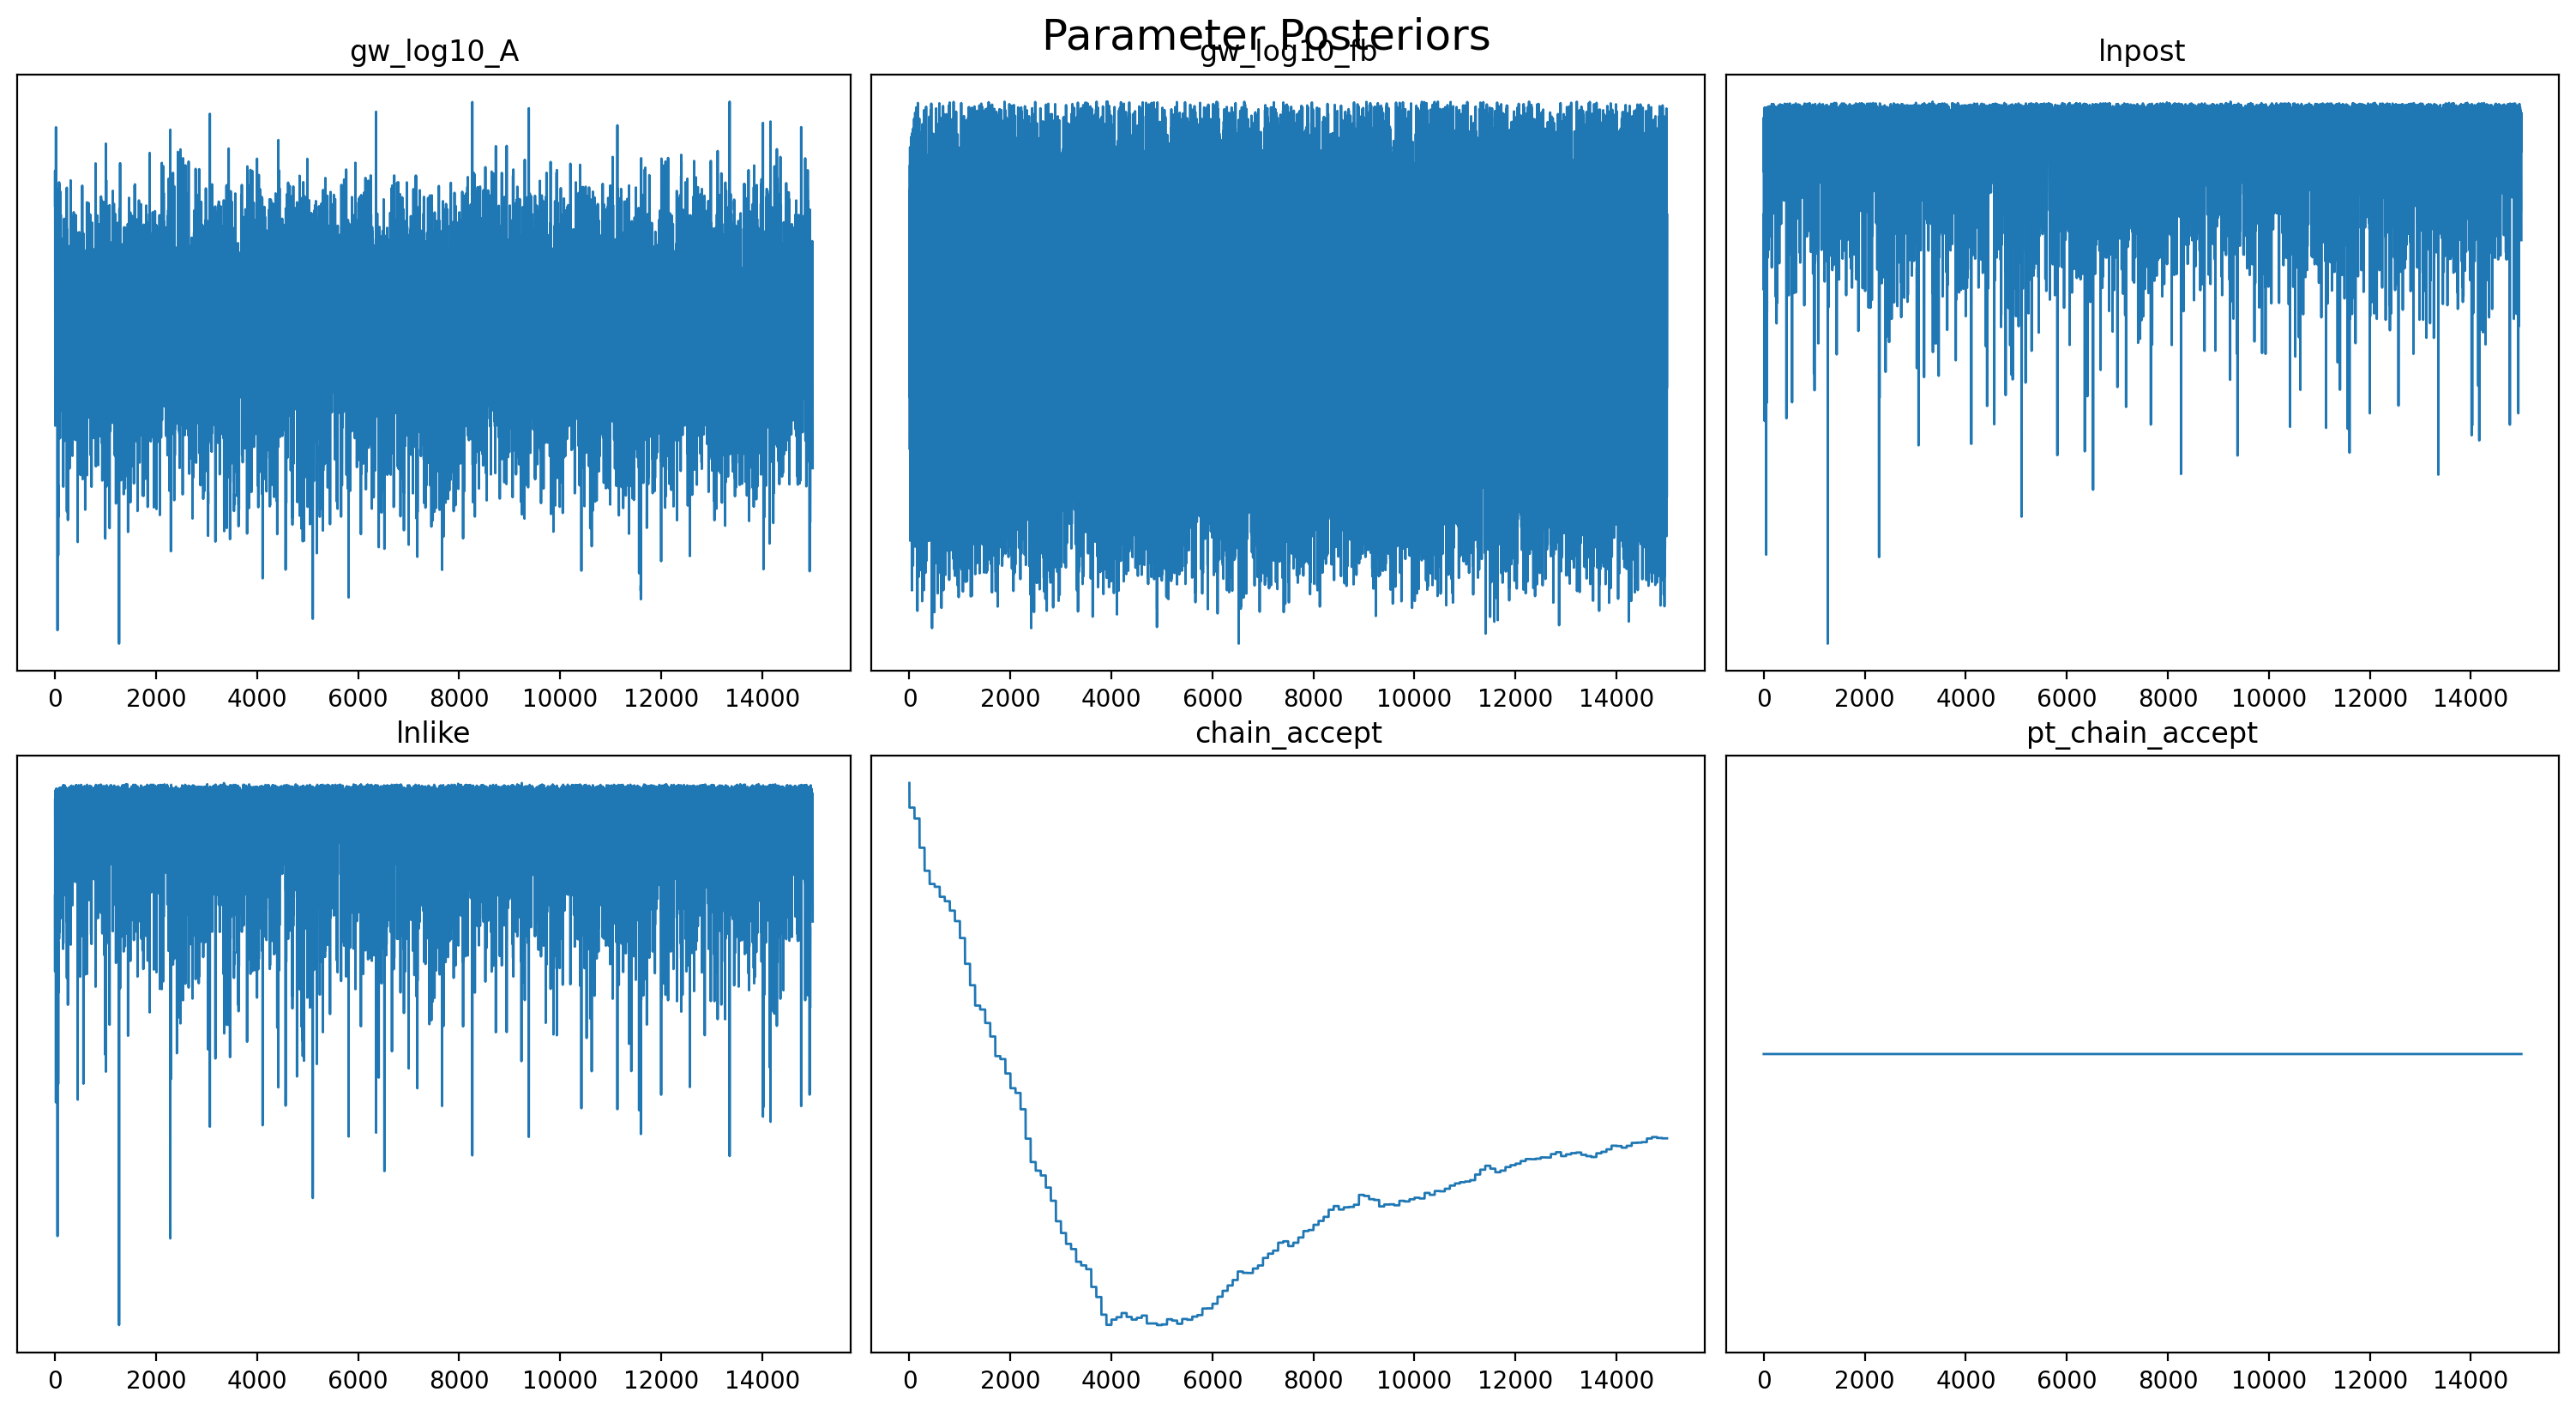

In [25]:
# checking the traceplot
dg.plot_chains(bpl10f, hist=False)

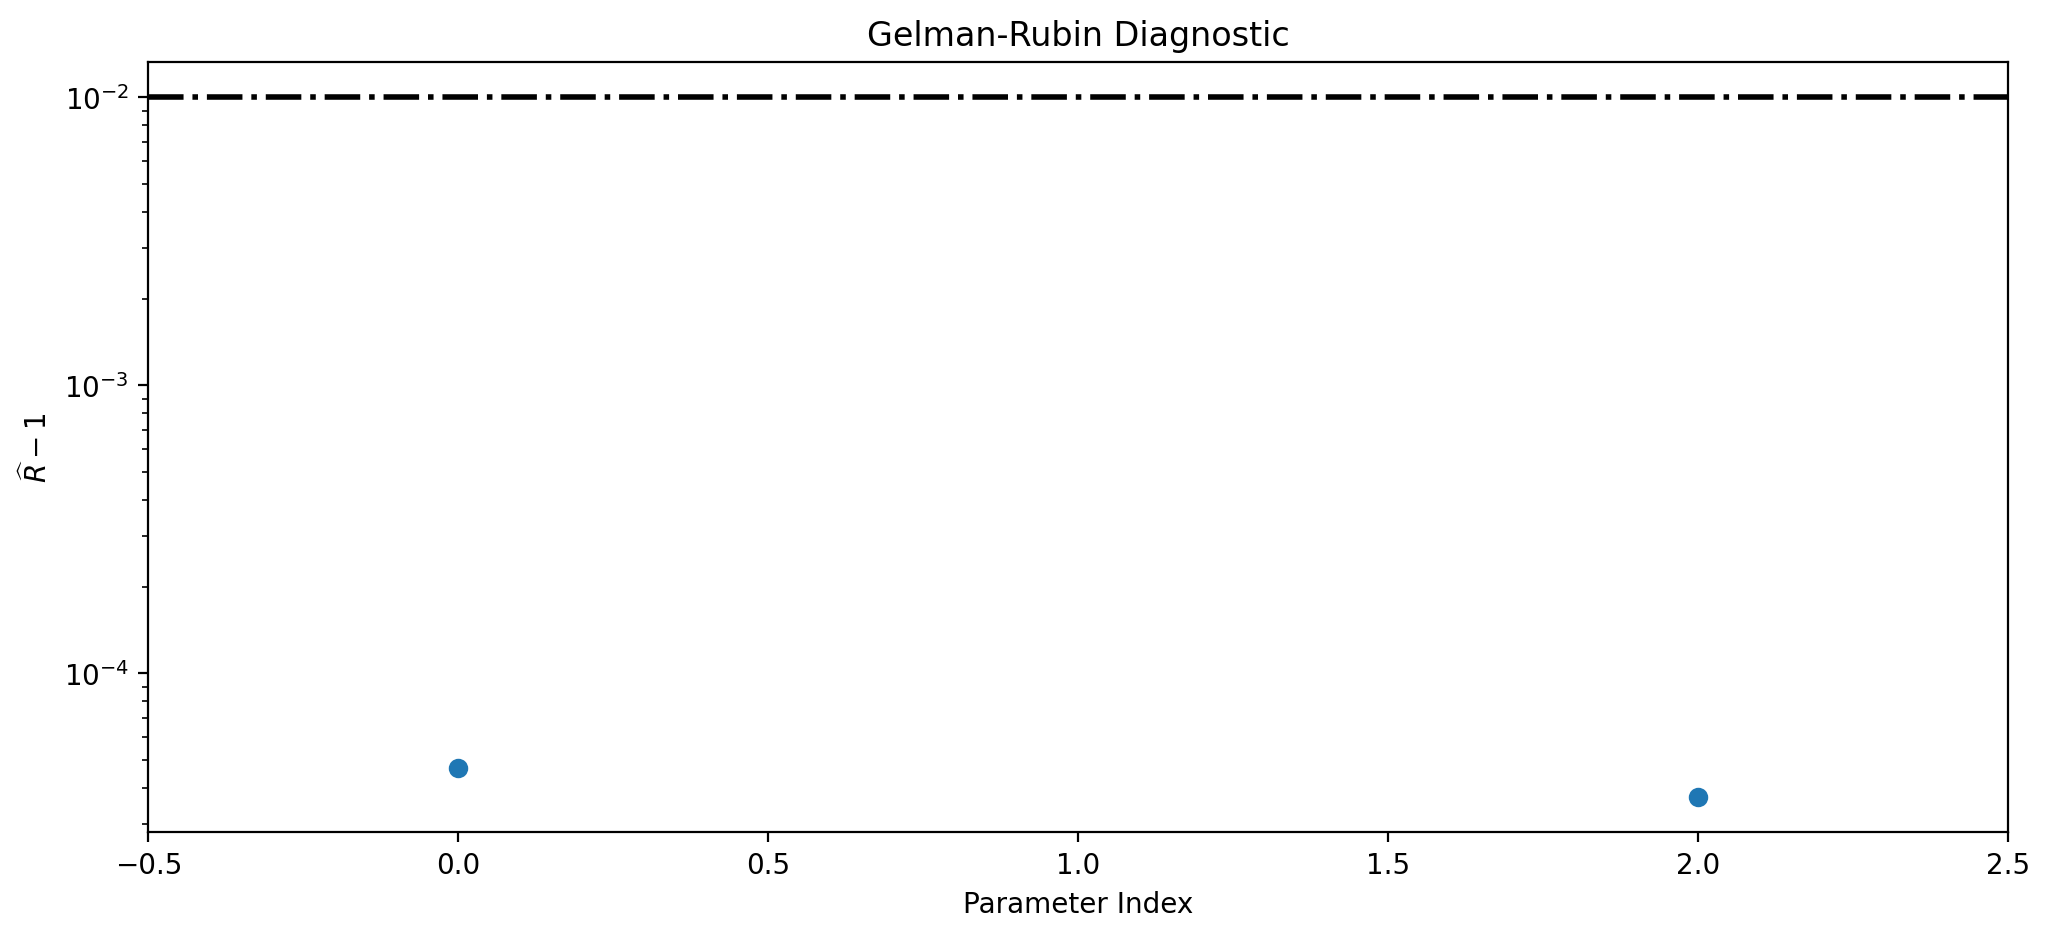

In [26]:
dg.plot_grubin(bpl10f)

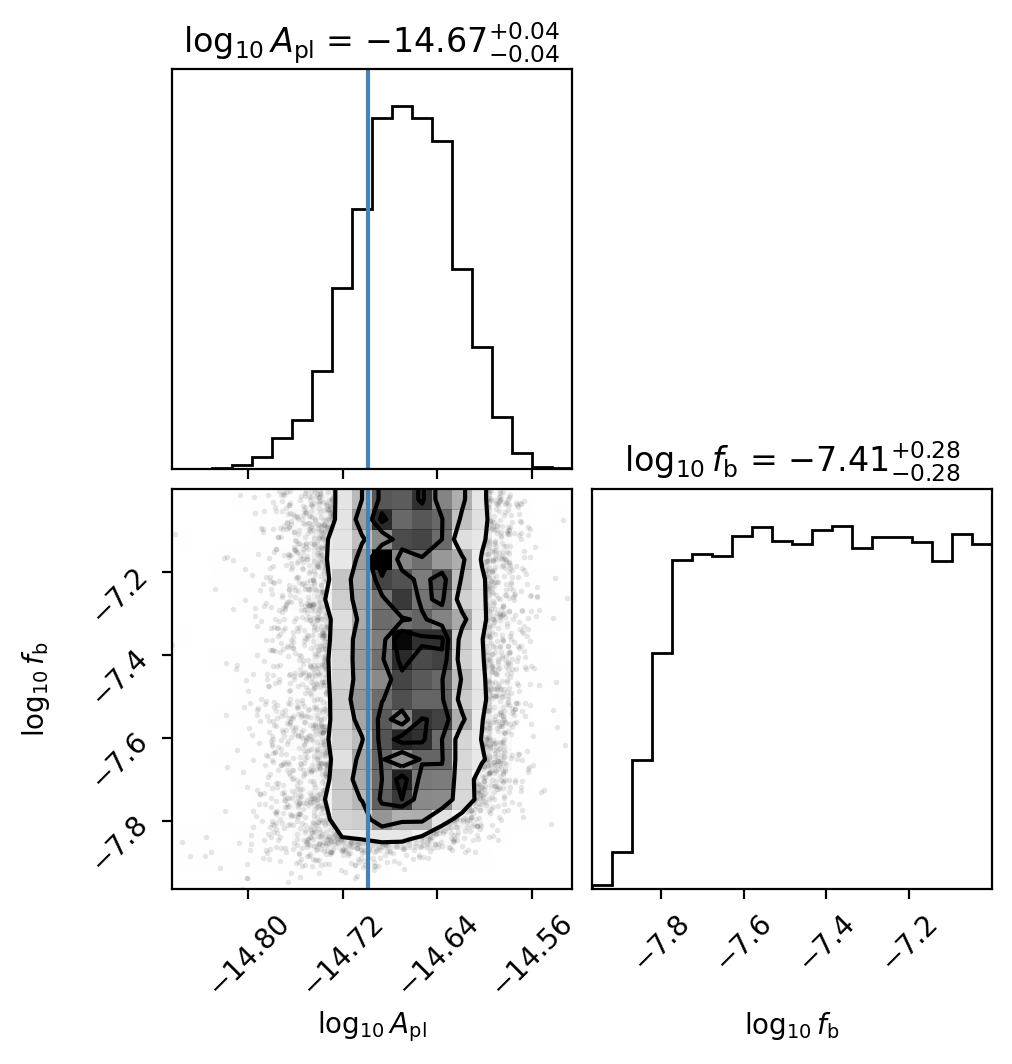

In [28]:
# let's make a corner plot!
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\log_{10}f_\mathrm{b}$']

corner.corner(bpl10f(bpl10f.params[:2]), labels=tex,
              show_titles=True, truths=[log10A_inj, None]);

this run really captured the injected amplitude well!

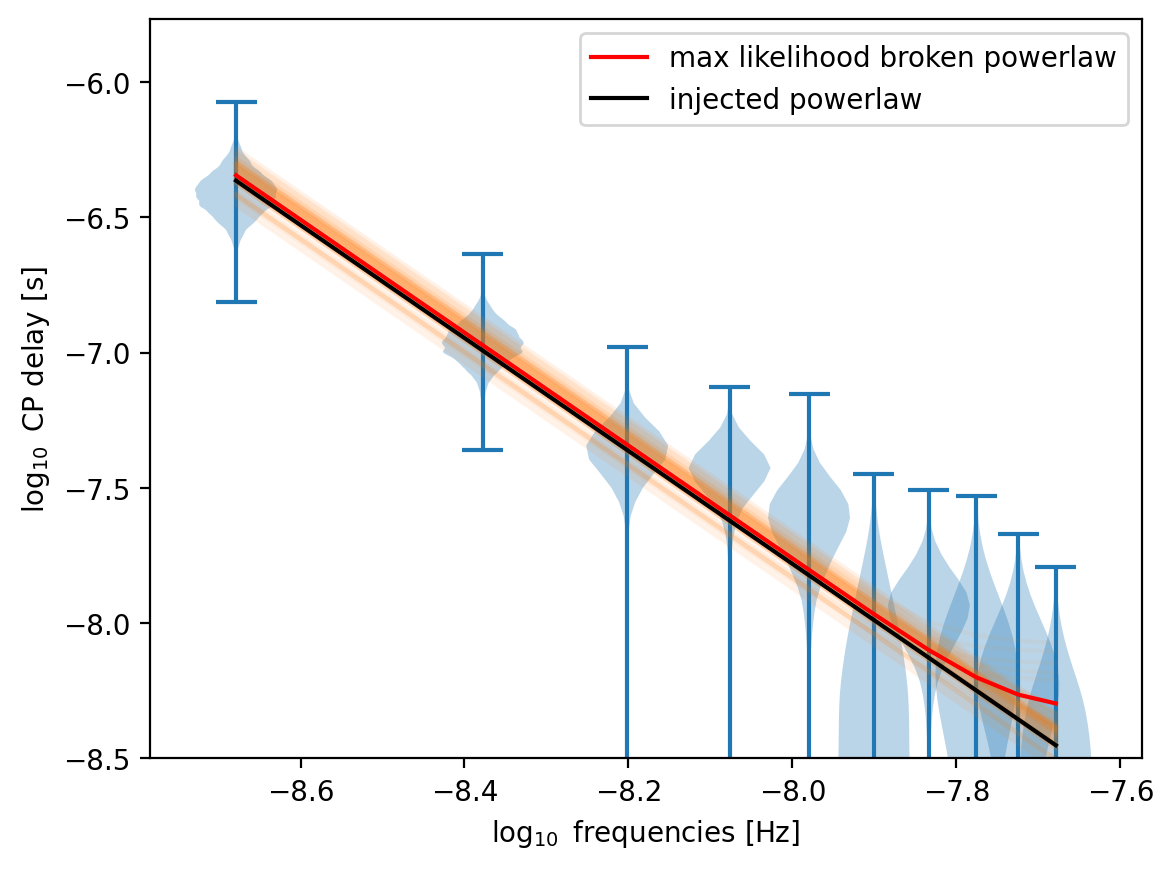

In [42]:
"""  # DON'T RUN THIS BLOCK!
idx = np.where(bpl10f('lnpost').max()==bpl10f('lnpost'))[0][0]
log10_A, log10_fb = bpl10f.chain[bpl10f.burn:][idx][:2]

bpl = 0.5*np.log10(models.broken_powerlaw(bpl10f.rn_freqs,
                                          Tspan=1/pl5f.rn_freqs[0],
                                          log10_A=log10_A,
                                          gamma=gamma_inj, log10_fb=log10_fb))

idx = np.random.randint(0, bpl10f.chain[bpl10f.burn:].shape[0],
                        100)
log10_A, log10_fb = bpl10f.chain[bpl10f.burn:][idx][:,:2].T
plspread = 0.5*np.log10(models.broken_powerlaw(bpl10f.rn_freqs[None,:].T,
                                               Tspan=1/bpl10f.rn_freqs[0],
                                               log10_A=log10_A,
                                               gamma=gamma_inj,
                                               log10_fb=log10_fb))

pl_inj = 0.5*np.log10(models.powerlaw(bpl10f.rn_freqs,
                                      Tspan=1/bpl10f.rn_freqs[0],
                                      log10_A=log10A_inj,
                                      gamma=gamma_inj))

plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.plot(np.log10(bpl10f.rn_freqs), plspread, color='C1', alpha=0.05)
plt.plot(np.log10(bpl10f.rn_freqs), bpl, label='max likelihood broken powerlaw',
         color='r')
plt.plot(np.log10(bpl10f.rn_freqs), pl_inj, label='injected powerlaw', color='k')
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
plt.ylim(-8.5)
plt.legend();
"""

## Defining your own spectrum model

Defining your own spectrum model is really easy! The function just needs to follow some standard input/output rules to make sure it works properly in $\textit{ceffyl}$!

**First rule:** the first two arguments should be the keywords `f` (an array of frequencies) and `Tspan` (the timespan of the data set).

**Second rule:** the input array `f` has shape ($N_f$, 1) for the PTA free spectrum analysis. This is for vectorisation purposes. You can find this array as `pta.reshaped_freqs`. The output spectrum should therefore result in a ($N_f$, 1) vector.

In [10]:
pta.reshaped_freqs.shape

(10, 1)

In [11]:
models.powerlaw(pta.reshaped_freqs, pta.Tspan).shape

(10, 1)

The arguments after `f` and `Tspan` can then be anything you want!

The returned function must be in units of $[s^2]$ corresponding to $\rho^2$, just like in `enterprise.gp_priors`.

See the [models](https://github.com/astrolamb/ceffyl/blob/main/ceffyl/models.py) script for examples

## ultranest

Model analysis with nested sampling is easy! Take your ceffyl object and easily put it your favourite nested sampler e.g. ultranest!

In [12]:
sampler1 = ultranest.ReactiveNestedSampler(pta.param_names,
                                          loglike=pta.ln_likelihood,
                                          transform=pta.hypercube,
                                          resume='overwrite',
                                          log_dir='../data/sim51/refits/5fpl_nested/')

In [13]:
result1 = sampler1.run()
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...
[ultranest] Widening roots to 506 live points (have 400 already) ...
[ultranest] Sampling 106 live points from prior ...
[ultranest] Widening roots to 655 live points (have 506 already) ...
[ultranest] Sampling 149 live points from prior ...


[ultranest] Explored until L=-3e+01   [-26.0774..-26.0774]*| it/evals=4281/7153 eff=59.8338% N=262   
[ultranest] Likelihood function evaluations: 7163
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -32.52 +- 0.06836
[ultranest] Effective samples strategy satisfied (ESS = 1606.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.07 tail:0.03 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -32.548 +- 0.204
  single instance: logZ = -32.548 +- 0.117
  bootstrapped   : logZ = -32.523 +- 0.201
  tail           : logZ = +- 0.030
insert order U test : converged: True correlation: inf iterations

    gw_log10_A          : -15.10│ ▁  ▁▁▁▁▁▁▁▁▁▂▂▂▄▄▅▆▇▇▇▇▆▅▃▂▂▁▁▁▁▁ ▁ ▁ │-13.72    -14.34 +- 0.15
    gw_gamma            

In [15]:
sampler2 = ultranest.ReactiveNestedSampler(pta2.param_names,
                                           loglike=pta2.ln_likelihood,
                                           transform=pta2.hypercube,
                                           resume='overwrite',
                                           log_dir='../data/sim0/refits/10fbpl_nested/')

In [16]:
result2 = sampler2.run()
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...
[ultranest] Widening roots to 550 live points (have 400 already) ...
[ultranest] Sampling 150 live points from prior ...
[ultranest] Widening roots to 762 live points (have 550 already) ...
[ultranest] Sampling 212 live points from prior ...


[ultranest] Explored until L=-7e+01   [-65.8354..-65.8286]*| it/evals=2968/5231 eff=50.9062% N=69  6  
[ultranest] Likelihood function evaluations: 5244
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Will add 10 live points (x1) at L=-8e+01 ...
[ultranest] Explored until L=-7e+01   [-65.8363..-65.8361]*| it/evals=3052/5877 eff=18.4834% N=101 
[ultranest] Likelihood function evaluations: 5902
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -70.67 +- 0.08188
[ultranest] Effective samples strategy satisfied (ESS = 1100.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.08 tail:0.18 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -70.650 +-

### Using output from nested sampling for model selection

We can compute a Bayes Factor by taking the ratio between Bayesian evidences from our nested sampler

From the output of `ultranest`:

In [20]:
"""
logbf_pl = result1['logz']
logbf_bpl = result2['logz']

bf = np.exp(logbf_pl - logbf_bpl)
"""

"\nlogbf_pl = result1['logz']\nlogbf_bpl = result2['logz']\n\nbf = np.exp(logbf_pl - logbf_bpl)\n"

NOTE: you must ensure that the number of frequencies between your models are equal! 